In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
df_train = pd.read_csv('./train.csv',index_col = 'id')
df_test = pd.read_csv('./test.csv',index_col =  'id')
df_train.sample(5)

,keyword,location,text,target
id,,,,
5873,hailstorm,Dicky Beach,@CouncilSCC it does say hailstorm,1
2220,chemical%20emergency,"Seattle, Washington",New #job opening at Downtown Emergency Service...,0
3489,derailed,L'Enfant Plaza Metro Station,1 of those days when ya don't realize till alr...,1
372,annihilation,NaN,@Barbi_Twins We need help-horses will die! Ple...,0
9438,survivors,NaN,Haunting memories drawn by survivors http://t....,1


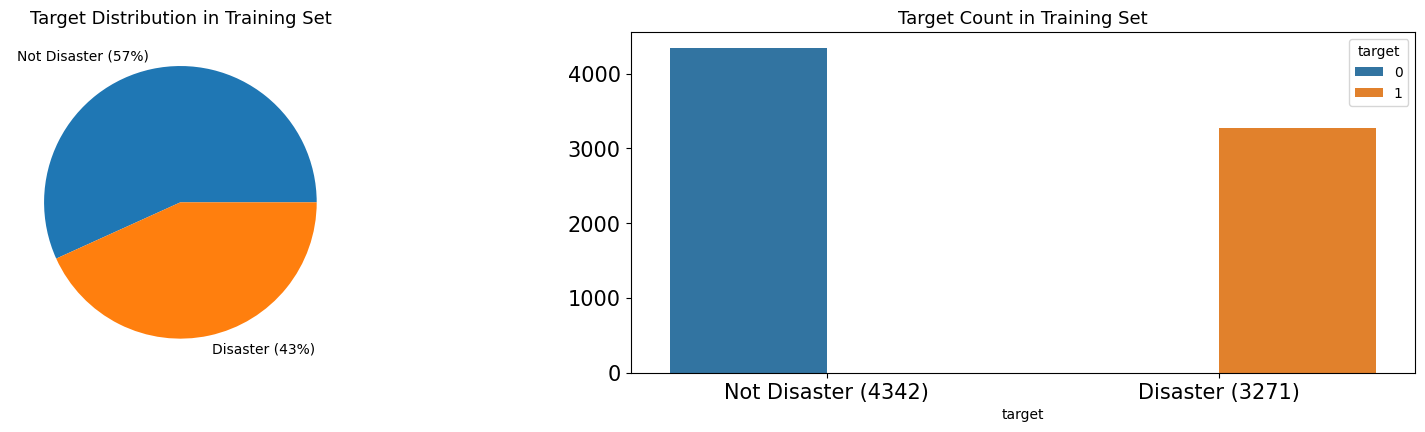

In [64]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count().location.plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()


In [65]:
print('# Null values in labels:',sum(df_train.target.isnull()))

# Null values in labels: 0


In [118]:
print('# Null values in keyword:',np.mean(df_train.keyword.isnull()))

# Null values in keyword: 0.008012610009194798


In [66]:
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (7613, 4)
Test shape: (3263, 3)


In [67]:

for df in [df_train, df_test]:
    for col in df.columns:
        print(col,np.round(sum(df[col].isna())/len(df_train),4),'na value')
    print()


keyword 0.008 na value
location 0.3327 na value
text 0.0 na value
target 0.0 na value

keyword 0.0034 na value
location 0.1451 na value
text 0.0 na value



In [68]:
df_train.keyword.fillna("unknown",inplace=True)
df_train.location.fillna("unknown",inplace=True)
df_test.keyword.fillna("unknown",inplace=True)
df_test.location.fillna("unknown",inplace=True)

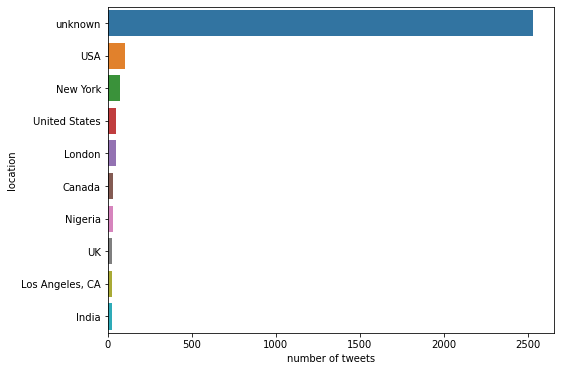

In [69]:
top20_loc = df_train.groupby(['location']).location.count().sort_values(ascending=False)[:10]
plt.figure(figsize = (8,6))
sns.barplot(x = top20_loc, y = top20_loc.index);
plt.xlabel('number of tweets');

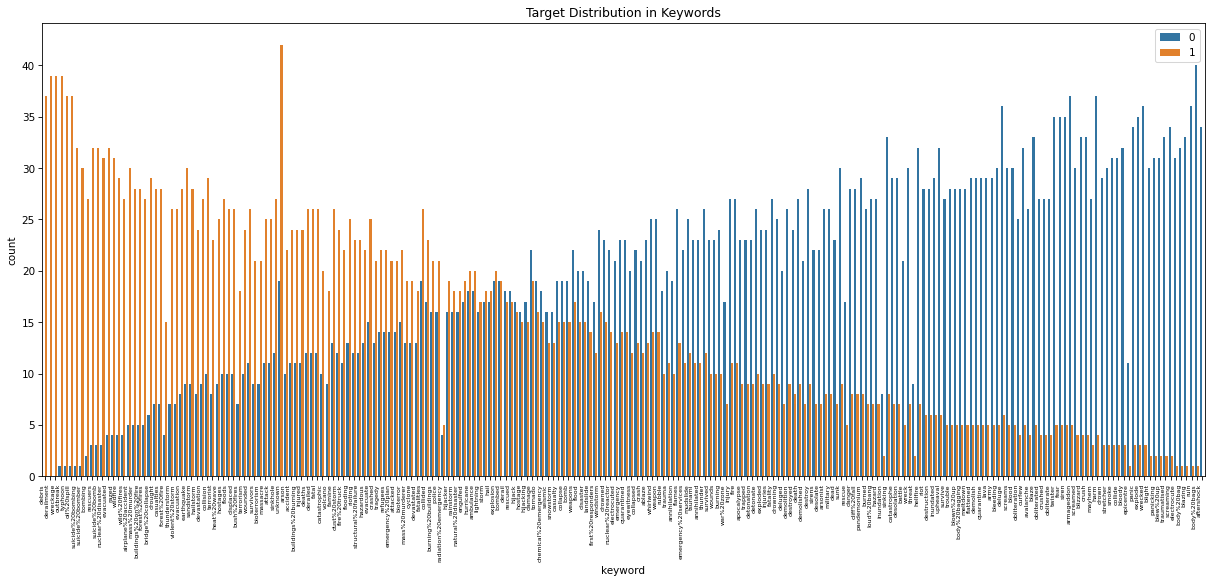

In [60]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(20, 8), dpi=75)
sns.countplot(x=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])
plt.tick_params(axis='x', labelsize=6)
plt.xticks(rotation=90, ha='right')
plt.tick_params(axis='y', labelsize=10)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')
plt.show()
df_train.drop(columns=['target_mean'], inplace=True)

In [108]:

def remove_accents(raw_text):
    raw_text = re.sub(u"[àáâãäå]", '', raw_text)
    raw_text = re.sub(u"[èéêë]", '', raw_text)
    raw_text = re.sub(u"[ìíîï]", '', raw_text)
    raw_text = re.sub(u"[òóôõö]", '', raw_text)
    raw_text = re.sub(u"[ùúûü]", '', raw_text)
    raw_text = re.sub(u"[ýÿ]", '', raw_text)
    raw_text = re.sub(u"[ß]", '', raw_text)
    raw_text = re.sub(u"[ñ]", '', raw_text)
    return raw_text

In [109]:
import unicodedata
def simplify(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)

In [70]:
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
import string

nltk.download('stopwords')
nltk.download('punkt')

nltk_st = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/sina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [110]:

def clean(tweet, http = True, punc = True, lem = True, stop_w = True):
    
    if http is True:
        tweet = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", '', tweet)
    
    tweet = [word.lower() for word in word_tokenize(tweet) if not word.lower() in nltk_st]
    tweet = ' '.join(tweet)
    
    
    tweet = [word for word in word_tokenize(tweet) if len(word) > 3]
    tweet = ' '.join(tweet)
    

    # lemmitizing
    if lem == True:
        lemmatized = [word.lemma_ for word in sp(tweet)]
        tweet = ' '.join(lemmatized)

    # punctuation removal
    if punc is True:
        tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    tweet = remove_accents(tweet)
    tweet = simplify(tweet)
    
    # removing extra space
    tweet = re.sub("\s+", ' ', tweet)
    
    return tweet


In [111]:
df_train['cleaned_text'] = df_train.text.apply(lambda x: clean(x, lem = False, stop_w = 'nltk', http = True, punc = True))


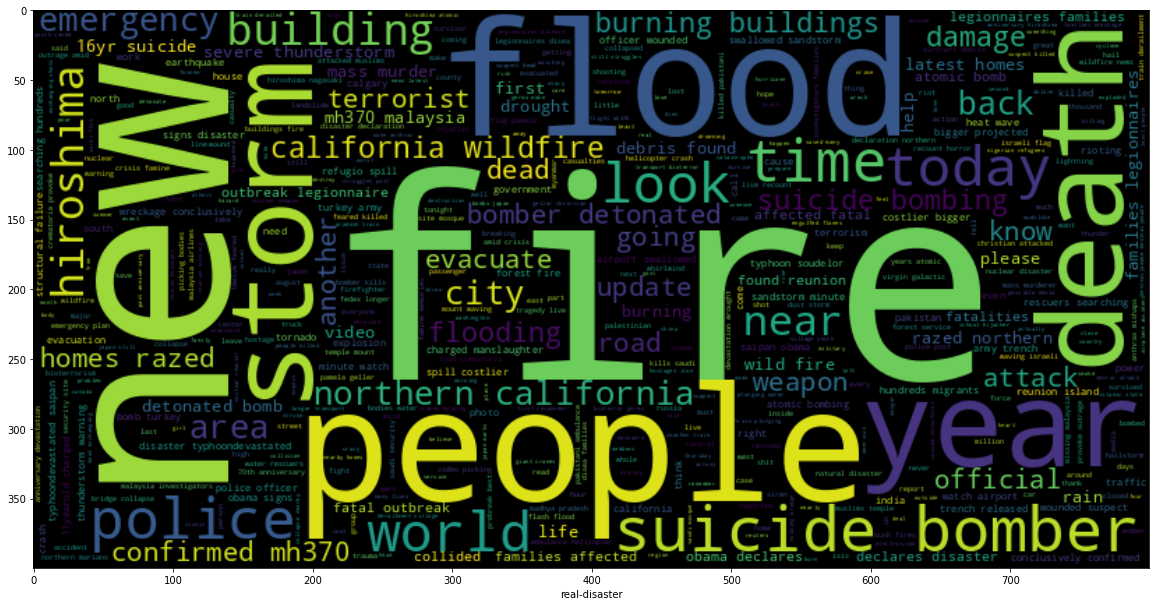

In [114]:


from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(df_train[df_train.target == 1].cleaned_text))
plt.xlabel("real-disaster")
plt.imshow(wc , interpolation = 'bilinear')



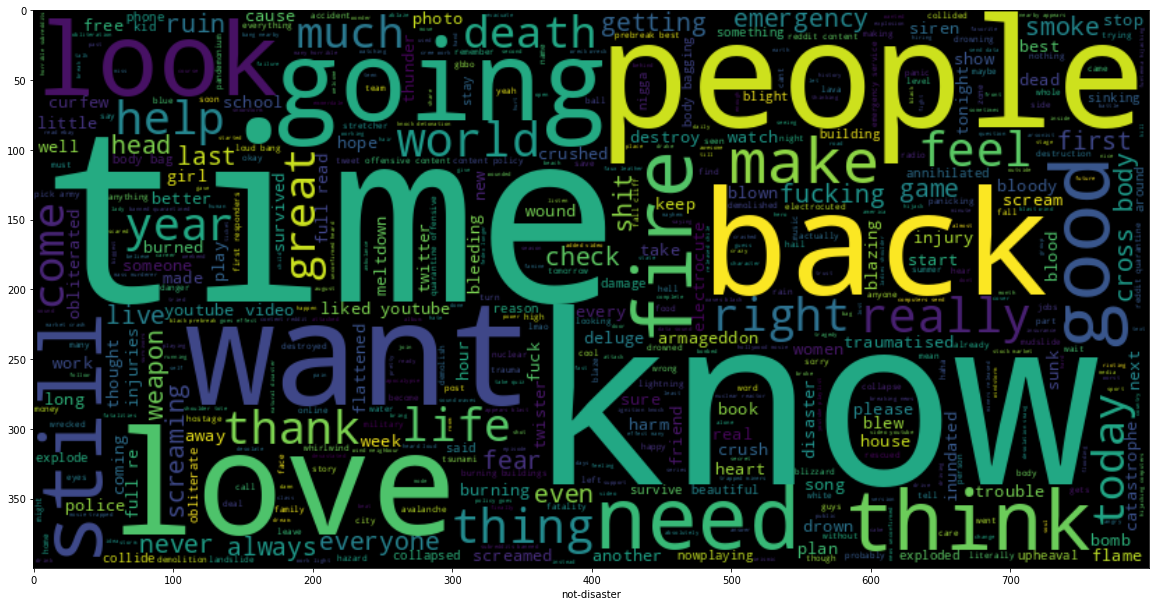

In [115]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(df_train[df_train.target == 0].cleaned_text))
plt.xlabel("not-disaster")
plt.imshow(wc , interpolation = 'bilinear')

